In [55]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [131]:

# preprocessing the data file
#  read the data
df1 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/drugsComTrain_raw.csv")
df2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/drugsComTest_raw.csv")
# combine two file
df = pd.concat([df1, df2])
df
# rename the cols
df.columns = ['ID','drug name','condition','review','rating','date','useful count']

In [10]:
df.head()

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [11]:
print("Train Shape :" , df1.shape)
print("Test Shape : ", df2.shape)

Train Shape : (161297, 7)
Test Shape :  (53766, 7)


Data Understanding


In [12]:
print("unique values count of train : " ,len(set(df1['uniqueID'].values)))
print("length of train : " ,df1.shape[0])

unique values count of train :  161297
length of train :  161297


Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

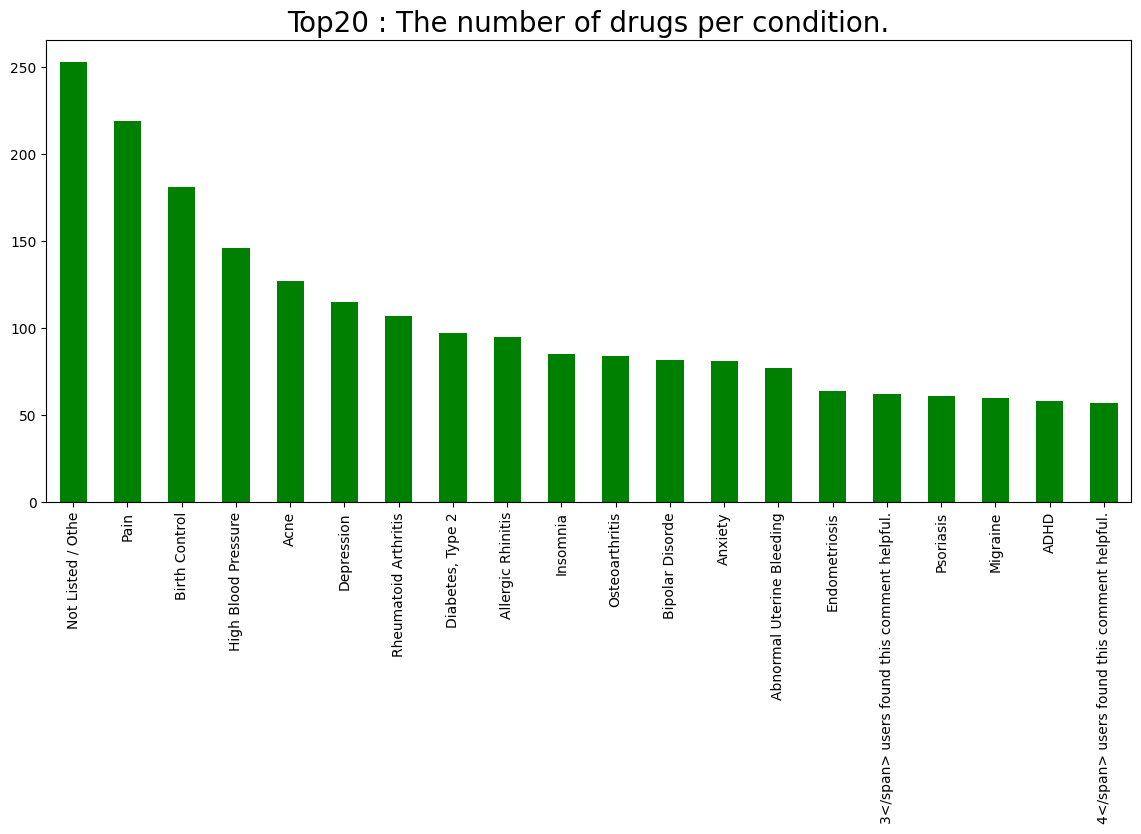

In [17]:
condition_dn = df.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

As you can see from the picture above, the number of drugs for top eight conditions is about 100 for each condition. On the other hand, it should be noted that the phrase "3</span> users found this comment helpful" appears in the condition, which seems like an error in the crawling process. I have looked into it to see in more details.

In [18]:
df[df['condition']=='3</span> users found this comment helpful.'].head(3)

,ID,drug name,condition,review,rating,date,useful count
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,1-Jun-10,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,16-Dec-15,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,12-Dec-15,3


It is expected that for structure of '</ span> users found this comment helpful.' phrase, there will be not only 3, but also 4 as shown above, and other numbers as well. We will remove these data in the future preprocessing.

The following are the low 20 conditions of 'drugs per condition'. As you can see, the number is all 1. Considering the recommendation system, it is not feasible to recommend with that when there is only one product. Therefore, we will analyze only the conditions that have at least 2 drugs per condition.

Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

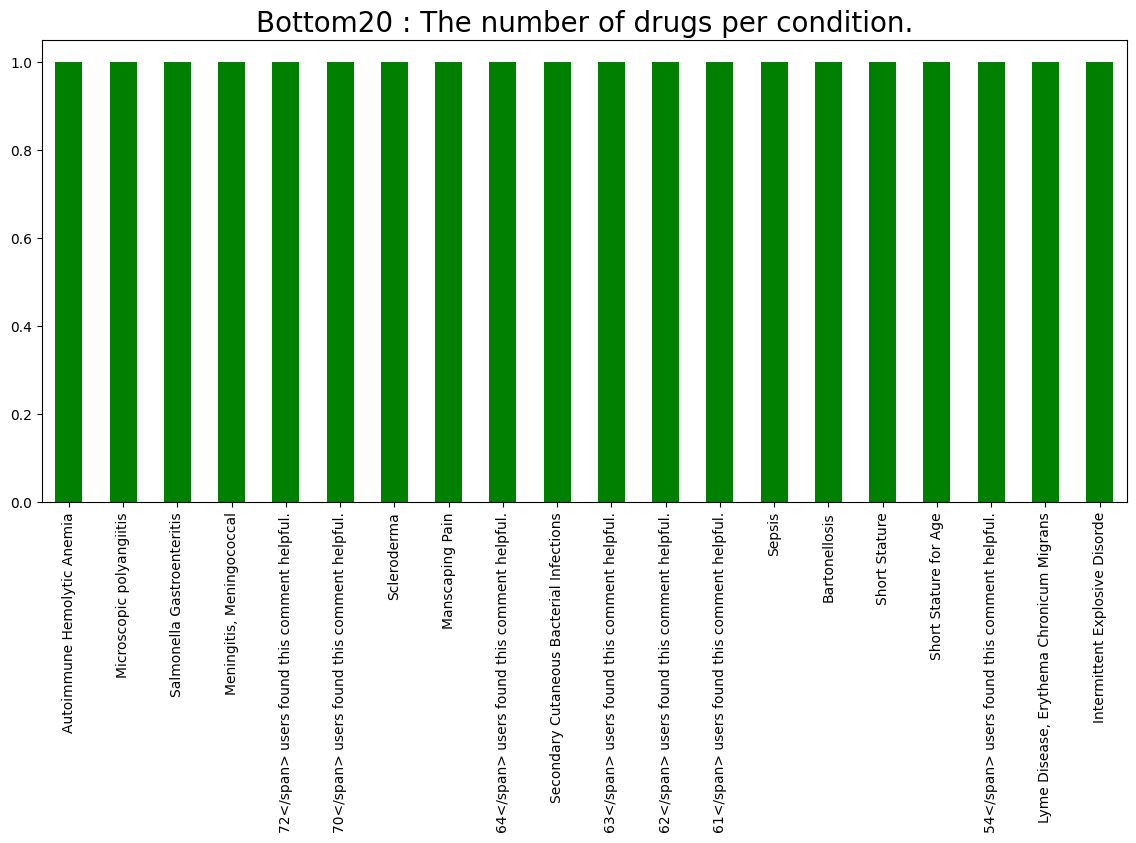

In [21]:
condition_dn = df.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

Next, let's have a look at the review. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH.

In [22]:
df1['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...

In [23]:
df1['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

We will delete these parts in preprocessing as well.

Next up, it's Word Cloud.

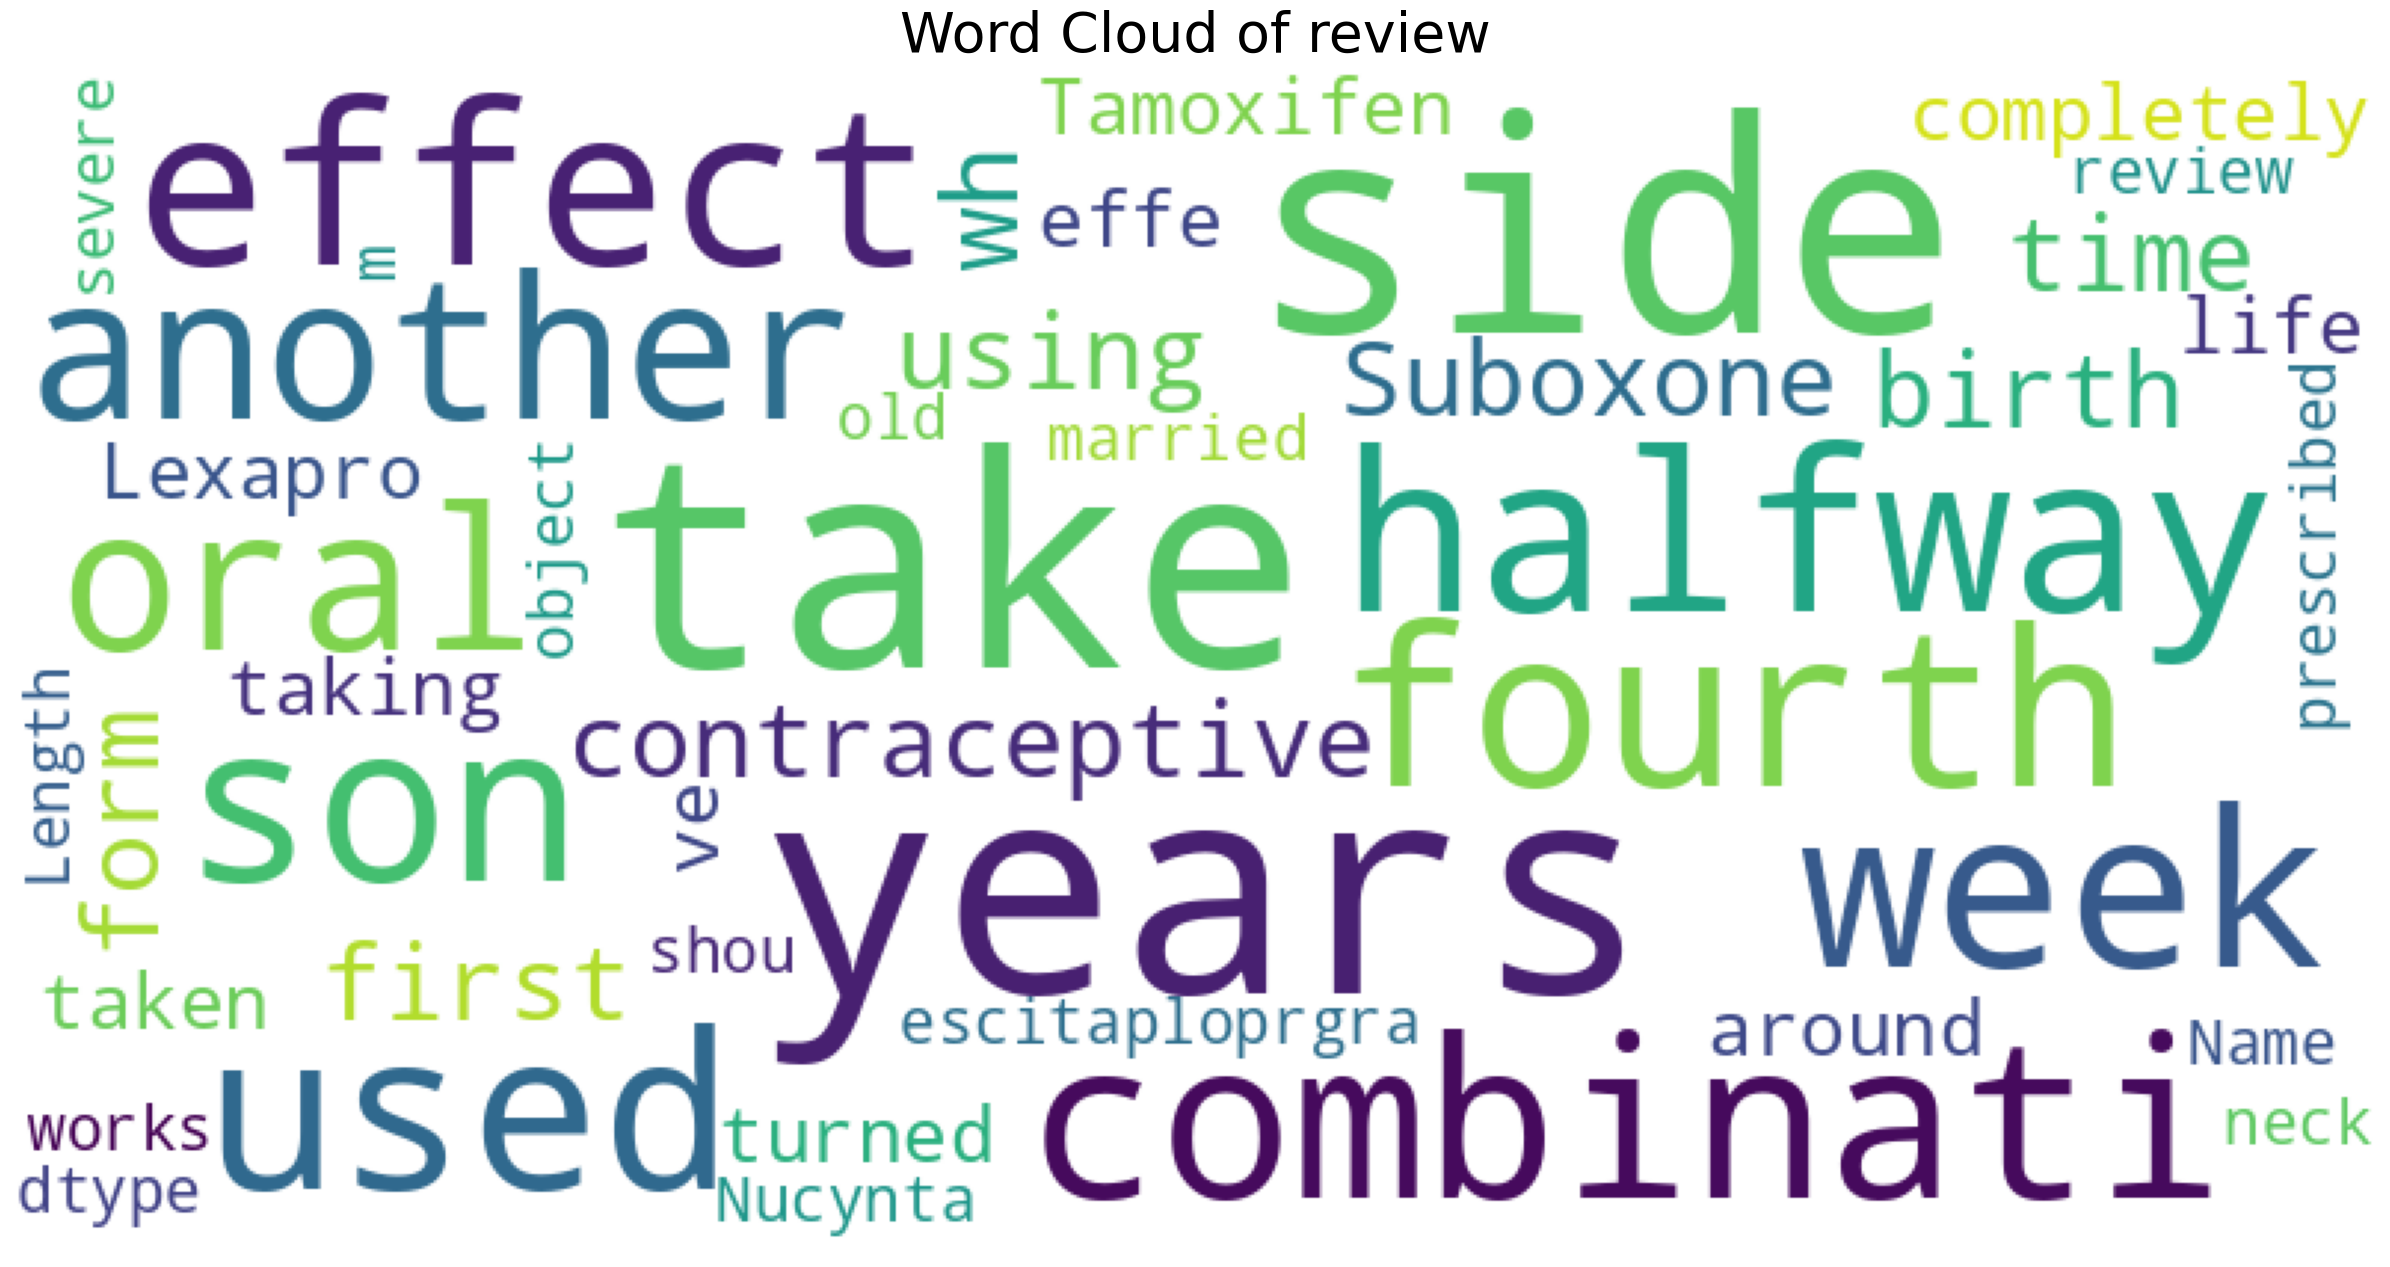

In [26]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(df["review"], title="Word Cloud of review")

Next, we will classify 1 ~ 5 as negative, and 6 ~ 10 as positive, and we will check through 1 ~ 4 grams which corpus best classifies emotions.

In [29]:
from collections import defaultdict
df_6_10 = df[df["rating"]>5]
df_1_5 = df[df["rating"]<6]

In [37]:
pip install plotly --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1


In [40]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from rating  8 to 10 review ##
freq_dict = defaultdict(int)
for sent in df_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from rating  4 to 7 review ##
freq_dict = defaultdict(int)
for sent in df_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=["Frequent words of rating 1 to 5", "Frequent words of rating 6 to 10"])


fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
fig.show()

When you use 1-gram, you can see that the top 5 words have the same contents, although the order of left (negative) and right (positive) are different. This means when we analyze the text with a single corpus, it does not classify the emotion well. So, we will expand the corpus.

In [43]:
freq_dict = defaultdict(int)
for sent in df_1_5["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df_6_10["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=["Frequent words of rating 1 to 5", "Frequent words of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
fig.show()

Likewise, in 2-gram, the contents of the top five corpus are similar, and it is hard to classify positive and negative. In addition, 'side effects' and 'side effects.' are interpreted differently, which means preprocessing of review data is necessary. However, you can see that this is better to classify emotions rather than previous 1-grams, like side effects, weight gain, and highly recommend.

In [45]:
freq_dict = defaultdict(int)
for sent in df_1_5["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df_6_10["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=["Frequent words of rating 1 to 5", "Frequent words of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
fig.show()

From 3-gram you can see that there is a difference between positive and negative corpus. Bad side effects, birth control pills, negative side effects are corpus that classify positive and negative. However, both positive and negative parts can be thought that it has missing parts that reverses the context, such as' not' in front of a corpus.

Text(0.5, 1.0, 'Count of rating values')

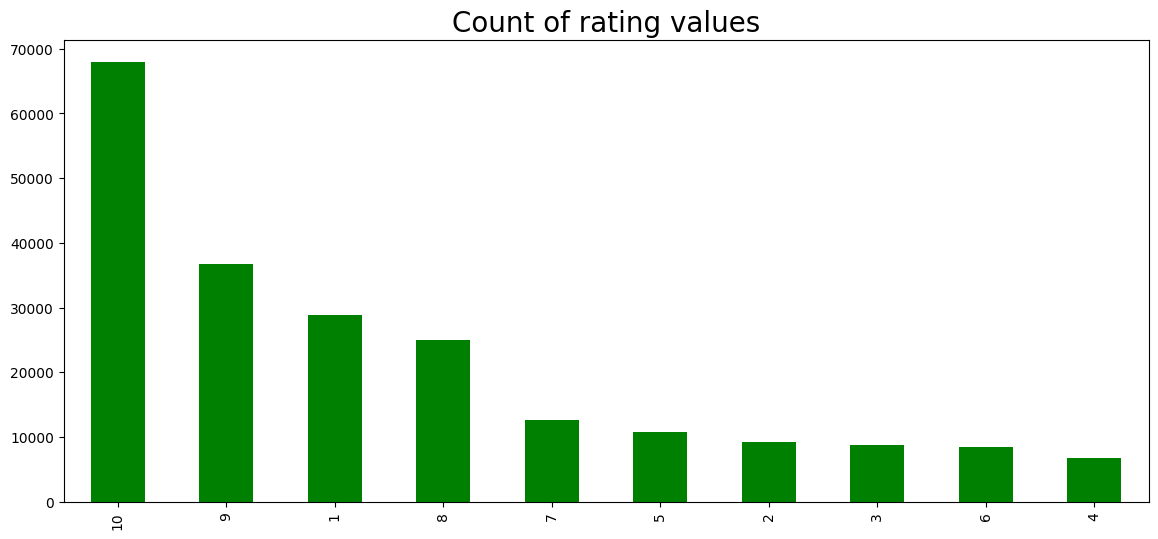

In [46]:
rating = df['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

Most people choose four values; 10, 9, 1, 8, and the number of 10 is more than twice as many as the others. With this, we can see that the percentage of positives is higher than negative, and people's reactions are extreme.

Next, we will check the number of reviews and percentage of ratings according to weather.

In [52]:
df['date'] = pd.to_datetime(df['date'])

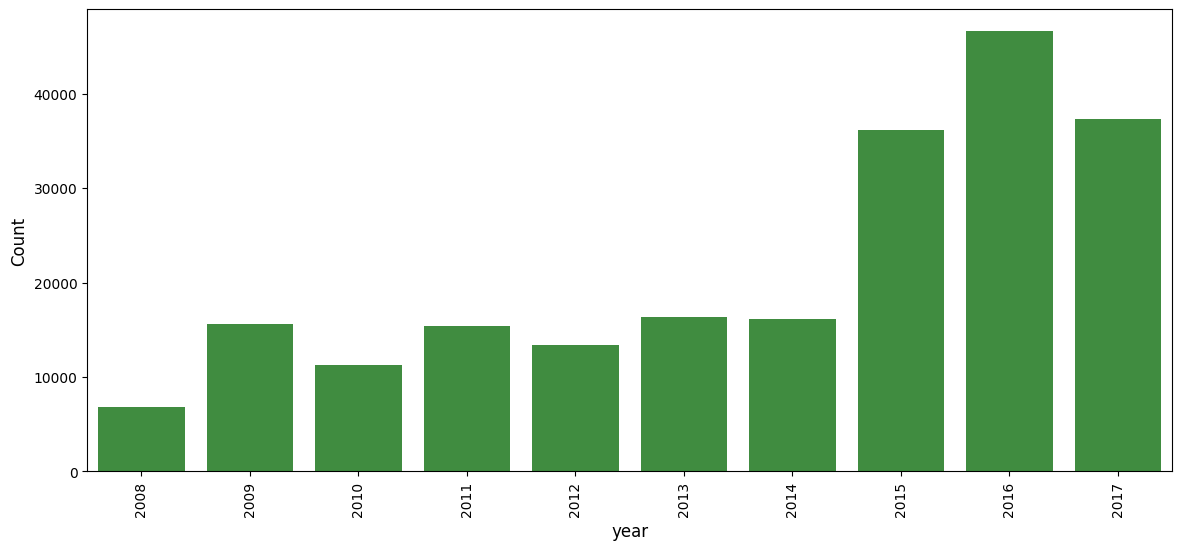

In [58]:
cnt_srs = df['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

Text(0.5, 1.0, 'Mean rating in year')

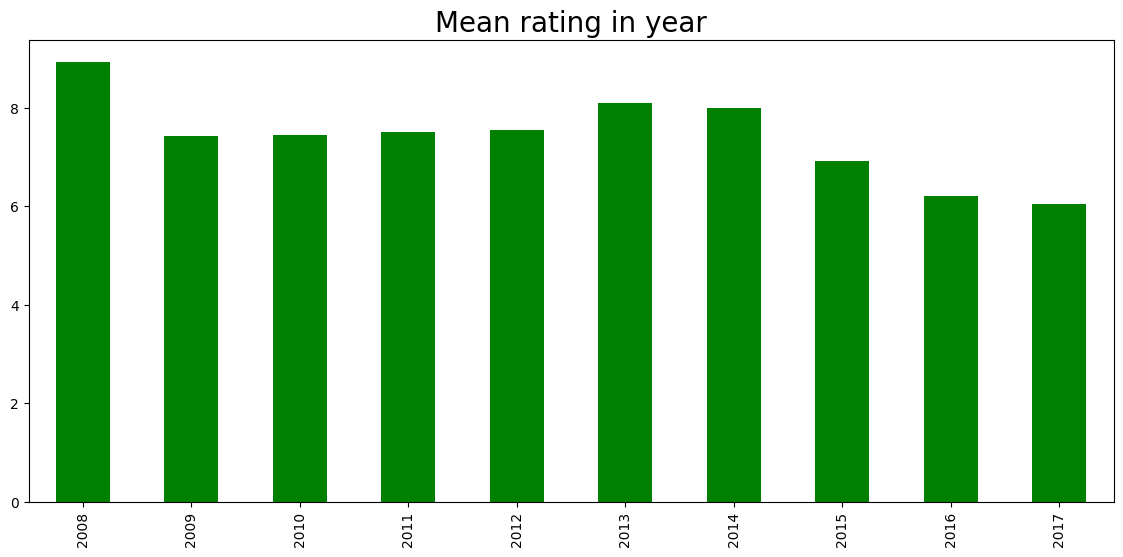

In [60]:
df['year'] = df['date'].dt.year
rating = df.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

<Figure size 1400x600 with 0 Axes>

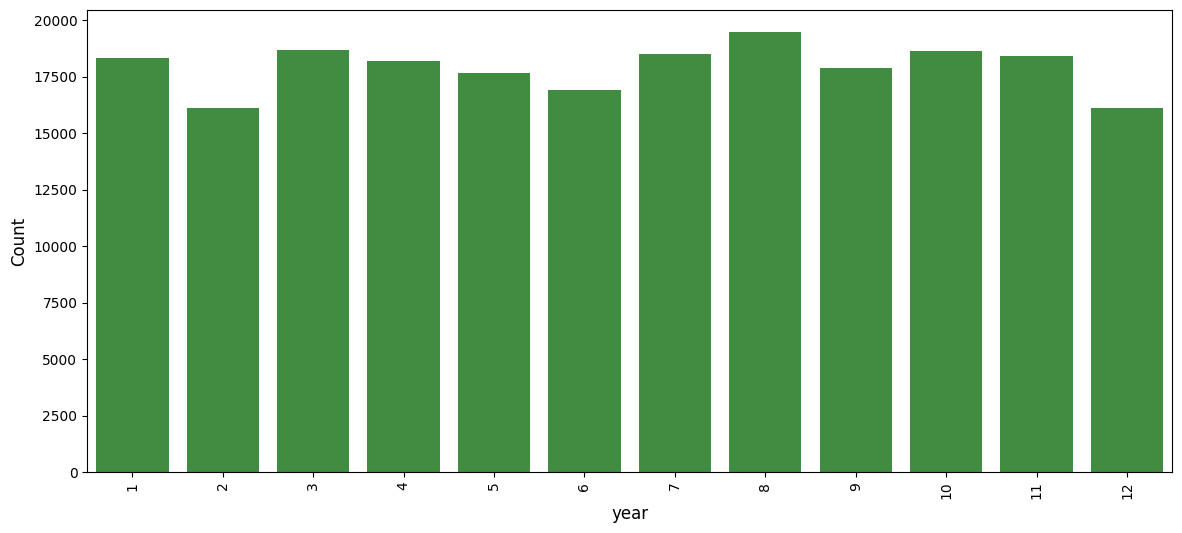

In [63]:
cnt_srs = df['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
plt.figure(figsize=(14,6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

Text(0.5, 1.0, 'Mean rating in month')

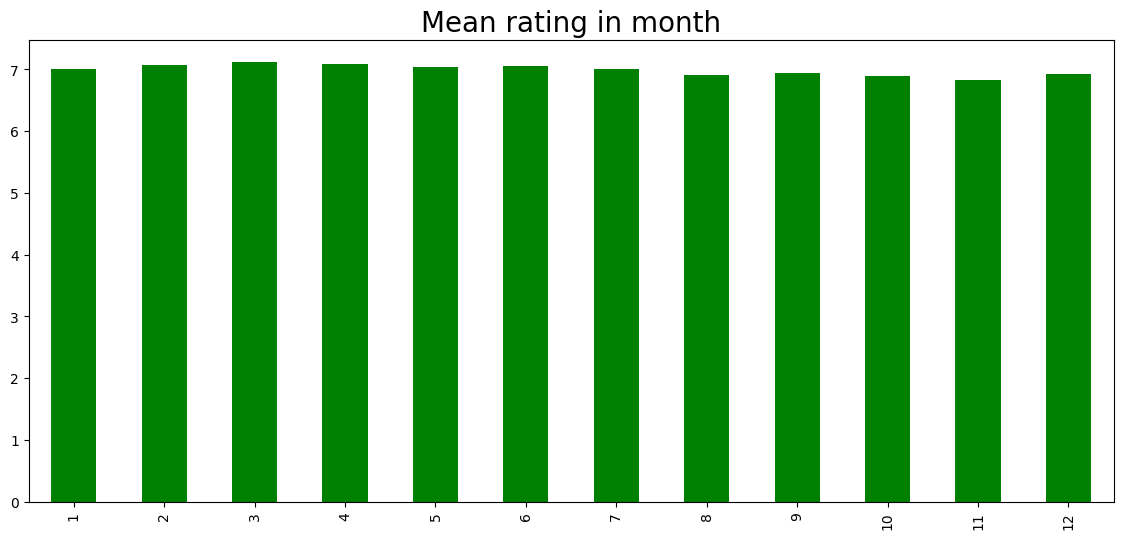

In [64]:
df['month'] = df['date'].dt.month
rating = df.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in month", fontsize = 20)

Text(0.5, 1.0, 'Mean rating in day')

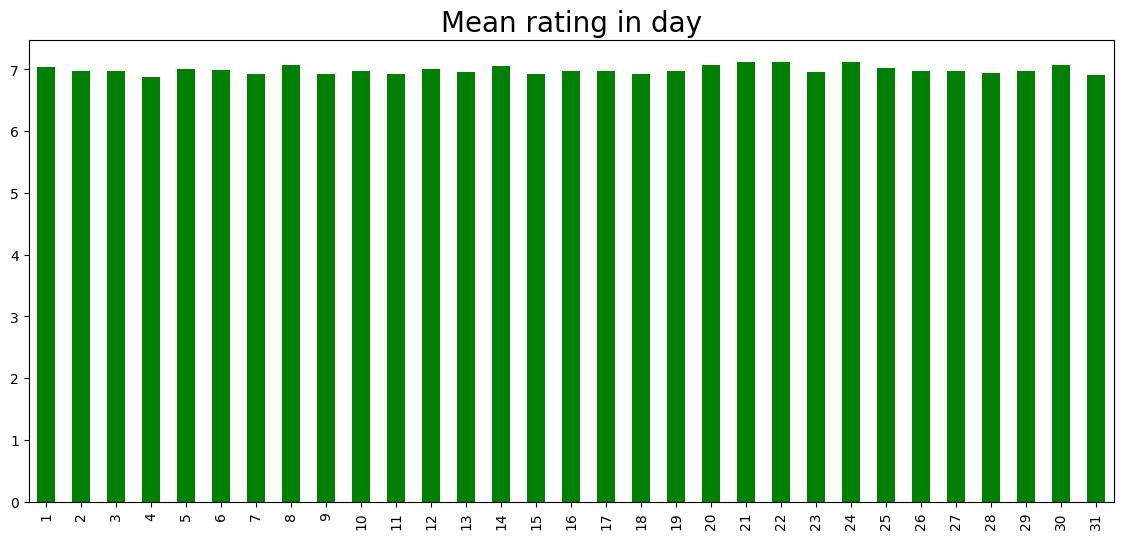

In [65]:
df['day'] = df['date'].dt.day
rating = df.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in day", fontsize = 20)

We checked whether the day of the week affects the rating like salary day, but it does not make a big difference.

<ipython-input-68-fdc77a0c1f67>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




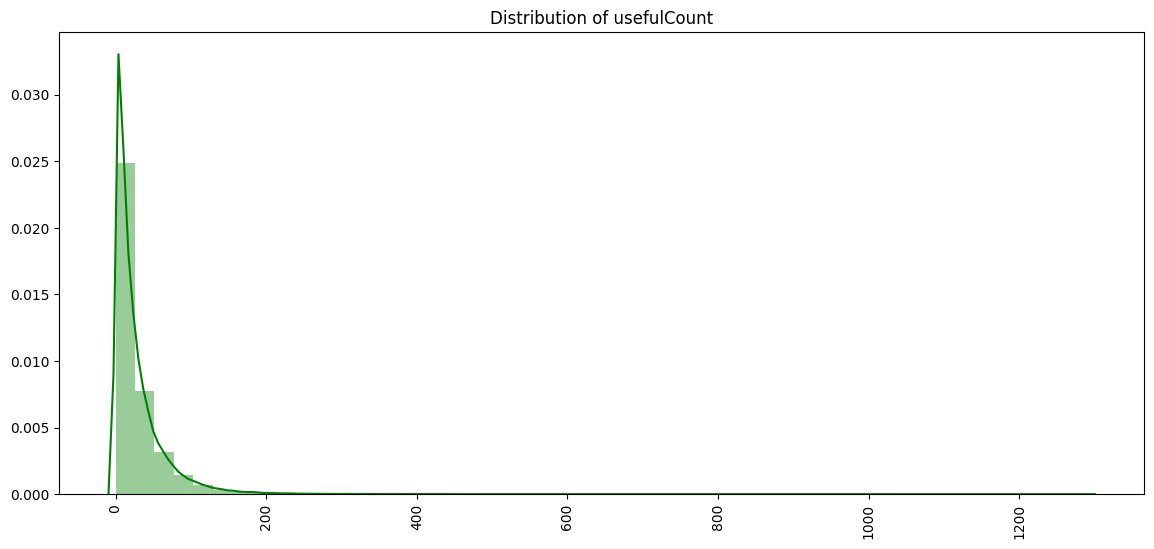

In [68]:
plt.figure(figsize=(14,6))
sns.distplot(df["useful count"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of usefulCount")
plt.show()

In [70]:
df["useful count"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: useful count, dtype: float64

If you look at the distribution of usefulCount, you can see that the difference between minimum and maximum is 1291, which is high. In addition, the deviation is huge, which is 36. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the usefulcount very high. So when we create the model, we will normalize it by conditions, considering people's accessibility.

**Missing Values**

Text(0.5, 1.0, 'Total Missing Value ')

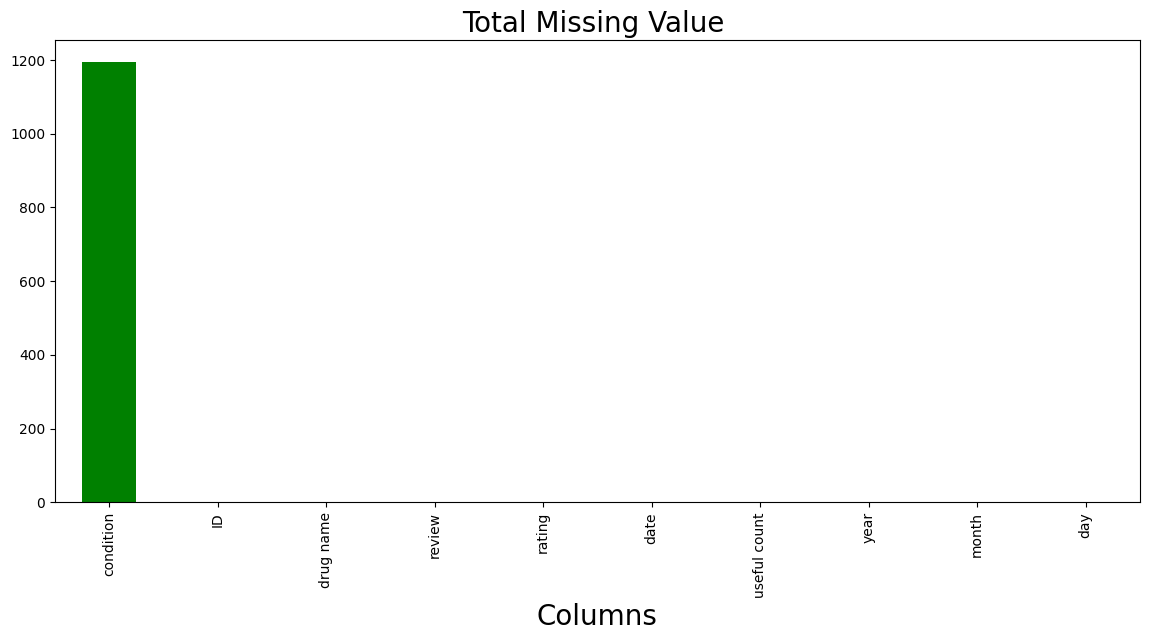

In [72]:
percent = (df.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [74]:
print("Missing value (%):", 1200/df.shape[0] *100)

Missing value (%): 0.5579760349292998


Condition Preprocessing

In [76]:
import math

span_list = []
for i, j in enumerate(df['condition']):
    if isinstance(j, str) and '</span>' in j:
        span_list.append(i)


In [77]:
new_idx = all_list.difference(set(span_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [79]:
df_condition = df.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drug name
791,"Organ Transplant, Rejection Reversal",1
792,Cerebrovascular Insufficiency,1
793,Cerebral Edema,1
794,"Paragonimus westermani, Lung Fluke",1
795,Parkinsonian Trem,1
796,Paroxysmal Supraventricular Tachycardia,1
797,Blepharitis,1
798,Patent Ductus Arteriosus,1
799,Pe,1
800,Pemphigoid,1


In [80]:
df_condition_1 = df_condition[df_condition['drug name']==1].reset_index()
df_condition_1['condition'][0:10]

0                Syringomyelia
1    mulation) (phenylephrine)
2      tic (mycophenolic acid)
3         Tuberculosis, Active
4    unctional Gastric Disorde
5          Transverse Myelitis
6        Upper Limb Spasticity
7                       mist (
8                          mis
9         Systemic Candidiasis
Name: condition, dtype: object

In [81]:
all_list = set(df.index)
condition_list = []
for i,j in enumerate(df['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

Review Preprocessing

In [82]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [86]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [89]:
stops = set(stopwords.words('english'))

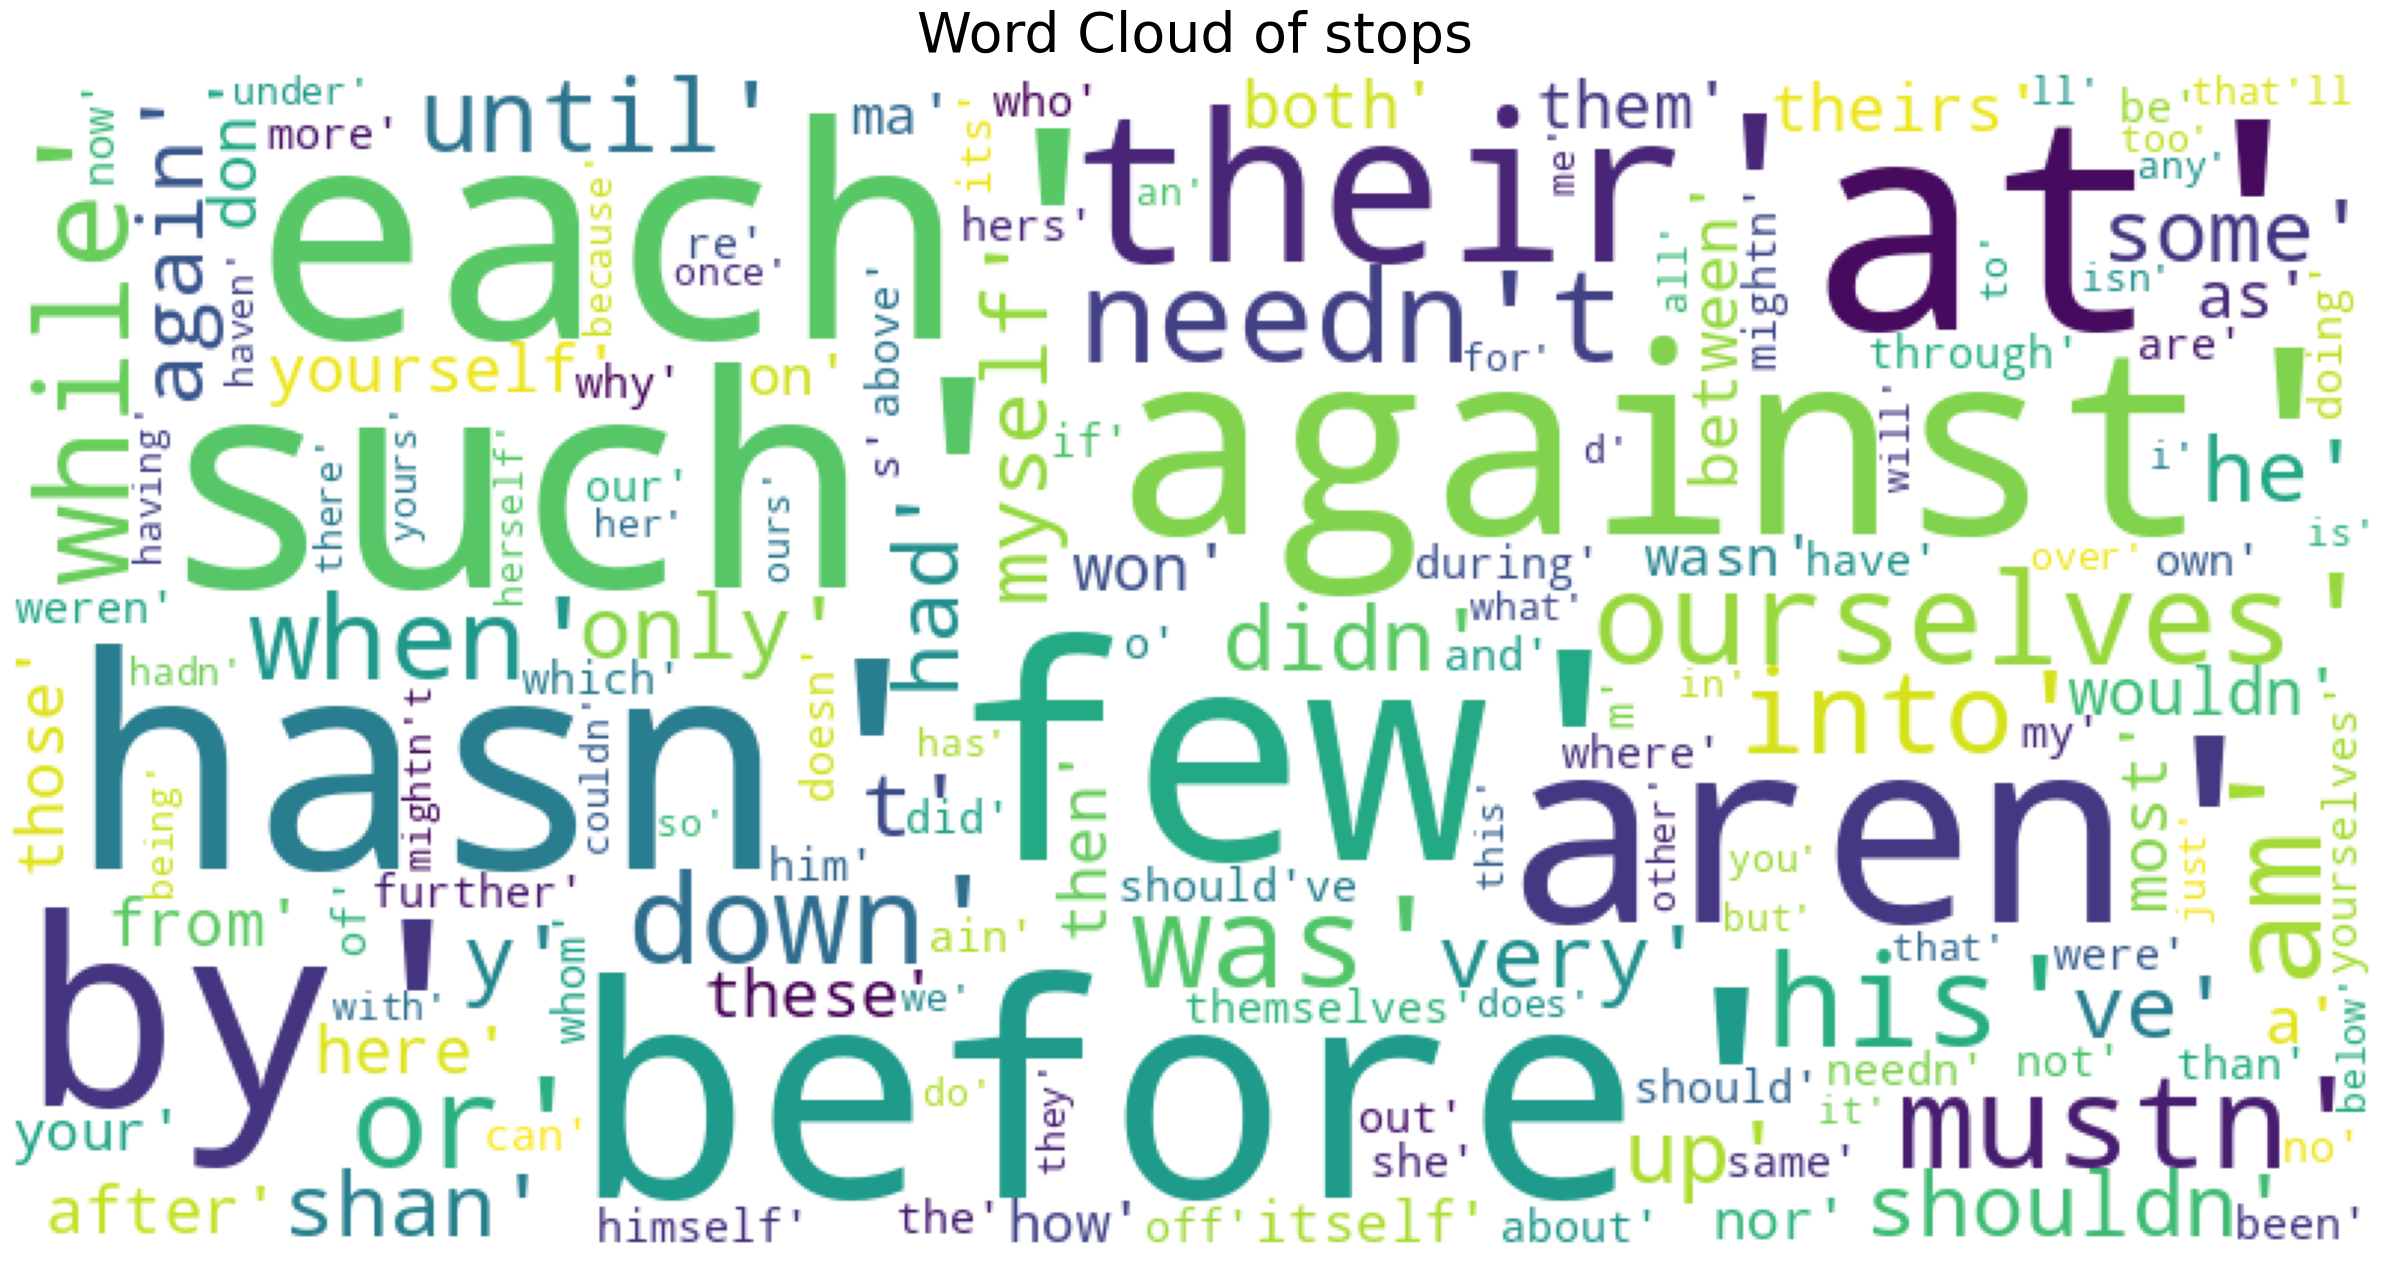

In [90]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(stops, title="Word Cloud of stops")

First, let's see what words are used as stopwords. There are many words that include not, like needn't. These words are key parts of emotional analysis, so we will remove them from stopwords.

In [91]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [133]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [134]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [135]:
%time df['review_clean'] = df['review'].apply(review_to_words)

<ipython-input-134-c92ea89fce1d>:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



CPU times: user 3min 15s, sys: 458 ms, total: 3min 15s
Wall time: 3min 29s


**MODEL**

In [136]:
df['sentiment'] = df["rating"].apply(lambda x: 1 if x > 5 else 0)

In [137]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [138]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(4, 4))

In [139]:
#https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [140]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])

CPU times: user 37.2 s, sys: 1.79 s, total: 39 s
Wall time: 39.3 s
CPU times: user 21.5 s, sys: 473 ms, total: 22 s
Wall time: 23 s


In [109]:
!pip install tensorflow==<version>
!pip install keras==<version>
!pip install numpy pandas nltk matplotlib seaborn


/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `pip install tensorflow==<version>'
/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `pip install keras==<version>'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
from tensorflow.python.keras.models import Sequential

In [113]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               4000200   
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               60300     
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                        

In [124]:
solution = df_test['sentiment']
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[    0, 15817],
       [    0, 36929]])